# Problem 4: Autoencoding motion of a charged particle in a magnetic field (Deadline: June 6)

In your Electromagnetism class you most probably learned that when a charged particle moves in a magnetic field it will follow either circular or a helical trajectory (depending on the direction of the B-field).

Very nice refresher of how this works can be found here:
([here](https://phys.libretexts.org/Bookshelves/University_Physics/Physics_(Boundless)/21%3A_Magnetism/21.4%3A_Motion_of_a_Charged_Particle_in_a_Magnetic_Field))

**Your task:**

Perform the following tasks for 

(a) circular trajecteries in 2D 

1. Generate training dataset of the trajectories. This dataset should use trajectories with different **initial angle and radius** (use your judgement to determine size and diversity of this dataset).

2. Build an auto-encoder (AE) neural network that will take a trajectory as an input, encodes it into **two-dimensional latent space** and then decodes it. The architecture and hyperparameter selection is, as always, up to you.

3. Plot the latent space and discuss the features you are observing.

4. Draw 5 random samples from the test set and plot both the sample and its reconstructed form. Comment on what you are observing in these plots.

(b) helical trajectories in 3D:

1. Generate training dataset of the trajectories. This dataset should use trajectories with different **initial angle, radius and initial z-velocity** (use your judgement to determine size and diversity of this dataset).

2. Build an auto-encoder (AE) neural network that will take a trajectory as an input, encodes it into **three-dimensional latent space** and then decodes it. The architecture and hyperparameter selection is, as always, up to you.

3. Plot the latent space and discuss the features you are observing. Comment specifically on why did you need the third dimension in the latent space.

4. Draw 5 random samples from the test set and plot both the sample and its reconstructed form - **please use a 3D plot**. Comment on what you are observing in these plots.

5. Add Gaussian noise to your training set and re-train your model. Repeat step 4 and comment on what you are observing. To which concept from the lectures can you relate the observed behavior?


*Tips for implementation:*

* You don't need to solve Maxwell's equations to generate the trajectories, just make resonably parametrized cicles and helices.

For example, something like this will suffice (for cirles):

    
* make sure you choose sufficient spread of radii and initial angles for circles and radii, initial angles and velocities for helices. If you do not have a diverse dataset the latent space will be harder to analyze.

* DO NOT make a VAE (we did that in the exercise notebook 5), here we just want you to make plain old AE as you learned in Lecture 5.


In [1]:
import numpy as np
import random as random
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset

In [2]:
def set_seed(seed=58):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [21]:
def GaussianNoise(trajectory, deviation=0.1):
    noise = np.random.normal(0, deviation * abs(trajectory))
    return trajectory + noise

def generate_trajectories(num_samples, num_points, dim, deviation = 0):
    """
    Generates an array of different trajectories. 
    Returns the array alongside an array for the radii and phis. 
    """
    trajectories = []
    radii_phi_z = []

    radii = np.random.uniform(0.1, 1.0, num_samples)  # radius of circle or helix
    phis = np.random.uniform(0.0, 2 * math.pi, num_samples)  # phase shift
    pitch = np.random.uniform(0.1, 1.0, num_samples)
    parametric_r = np.linspace(0.0, 2 * math.pi, num_points)  # parameter t
    if deviation == 0: 
        for i in range(num_samples):
            if dim == "2D":
                # Circular trajectory
                theta = np.linspace(0, 2 * math.pi, num_points)
                x = radii[i] * np.cos(theta + phis[i])
                y = radii[i] * np.sin(theta + phis[i])
                trajectories.append({'x': x.tolist(), 'y': y.tolist()})
                radii_phi_z.append([radii[i].tolist(), phis[i].tolist()])

            elif dim == "3D":
                # Helical trajectory
                x = radii[i] * np.cos(parametric_r + phis[i])
                y = radii[i] * np.sin(parametric_r + phis[i])
                z = pitch[i] * parametric_r
                trajectories.append({'x': x.tolist(), 'y': y.tolist(), 'z': z.tolist()})
                radii_phi_z.append([radii[i].tolist(), phis[i].tolist(), pitch[i]])
    if deviation != 0:
        for i in range(num_samples):
            if dim == "2D":
                # Circular trajectory
                theta = np.linspace(0, 2 * math.pi, num_points)
                x = radii[i] * np.cos(theta + phis[i])
                y = radii[i] * np.sin(theta + phis[i])
                x = GaussianNoise(x, deviation)
                y = GaussianNoise(y, deviation)
                trajectories.append({'x': x.tolist(), 'y': y.tolist()})
                radii_phi_z.append([radii[i].tolist(), phis[i].tolist()])

            elif dim == "3D":
                # Helical trajectory
                x = radii[i] * np.cos(parametric_r + phis[i])
                y = radii[i] * np.sin(parametric_r + phis[i])
                z = pitch[i] * parametric_r
                x = GaussianNoise(x, deviation=deviation)
                y = GaussianNoise(y, deviation=deviation)
                z = GaussianNoise(z, deviation=deviation)
                trajectories.append({'x': x.tolist(), 'y': y.tolist(), 'z': z.tolist()})
                radii_phi_z.append([radii[i].tolist(), phis[i].tolist(), pitch[i]])
        # else:
        #     print("Unsupported dimension: pass '2D' or '3D'")
        #     break

    
    return trajectories, np.array(radii_phi_z)


class TrajectoryDataset(Dataset):
    """ 
    Generates Dataset feedable to the neural network. 
    
    """
    def __init__(self, num_samples, num_points, dim, deviation):
        if deviation == 0: 
            trajectories, radii_phi_z = generate_trajectories(num_samples, num_points, dim, deviation = 0)
            self.trajectories = trajectories
            self.radii_phi_z = radii_phi_z
            self.dim = dim
            self.num_points = num_points
            self.flat_data = self._flatten_trajectories()
        if deviation != 0: 
            trajectories, radii_phi_z = generate_trajectories(num_samples, num_points, dim, deviation=deviation)
            self.trajectories = trajectories
            self.radii_phi_z = radii_phi_z
            self.dim = dim
            self.num_points = num_points
            self.flat_data = self._flatten_trajectories()

    def _flatten_trajectories(self):
        flat = []
        for traj in self.trajectories:
            if self.dim == "2D":
                data = np.stack([traj['x'], traj['y']], axis=1).flatten()
            elif self.dim == "3D":
                data = np.stack([traj['x'], traj['y'], traj['z']], axis=1).flatten()
            else:
                raise ValueError("Unsupported dimension")
            flat.append(data)
        return torch.tensor(flat, dtype=torch.float32)

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        return self.flat_data[idx], self.radii_phi_z[idx]

# Models for 2D and 3D. They are almost identical except the latent-dimension being 2 and 3 respectively.
class Autoencoder2D(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
class Autoencoder3D(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# 2D

def train_model(num_samples, num_points, dim, epochs, deviation):
    
    dataset = TrajectoryDataset(num_samples, num_points, dim, deviation=deviation)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    if dim == "2D":
        input_dim = 2 * num_points  # x and y
        model = Autoencoder2D(input_dim=input_dim)

    if dim == "3D":
        input_dim = 3 * num_points  # x, y and z
        model = Autoencoder3D(input_dim=input_dim)
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    epochs_array = []
    losses = []
    for epoch in range(epochs):
        epochs_array.append(epoch)
        total_loss = 0
        for batch, _ in loader:
            optimizer.zero_grad()
            x_hat, _ = model(batch)
            loss = loss_fn(x_hat, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #print(f"Epoch {epoch+1}, Loss = {total_loss / len(loader):.4f}")
        losses.append(total_loss / len(loader))
        
    return epochs_array, losses, dataset, model, deviation

**Plotting Trajectories:**

Below figures 4 plots of 50 helical and circular trajectories with and without noise.

The noise is set to 0.01 in random.normal(). 

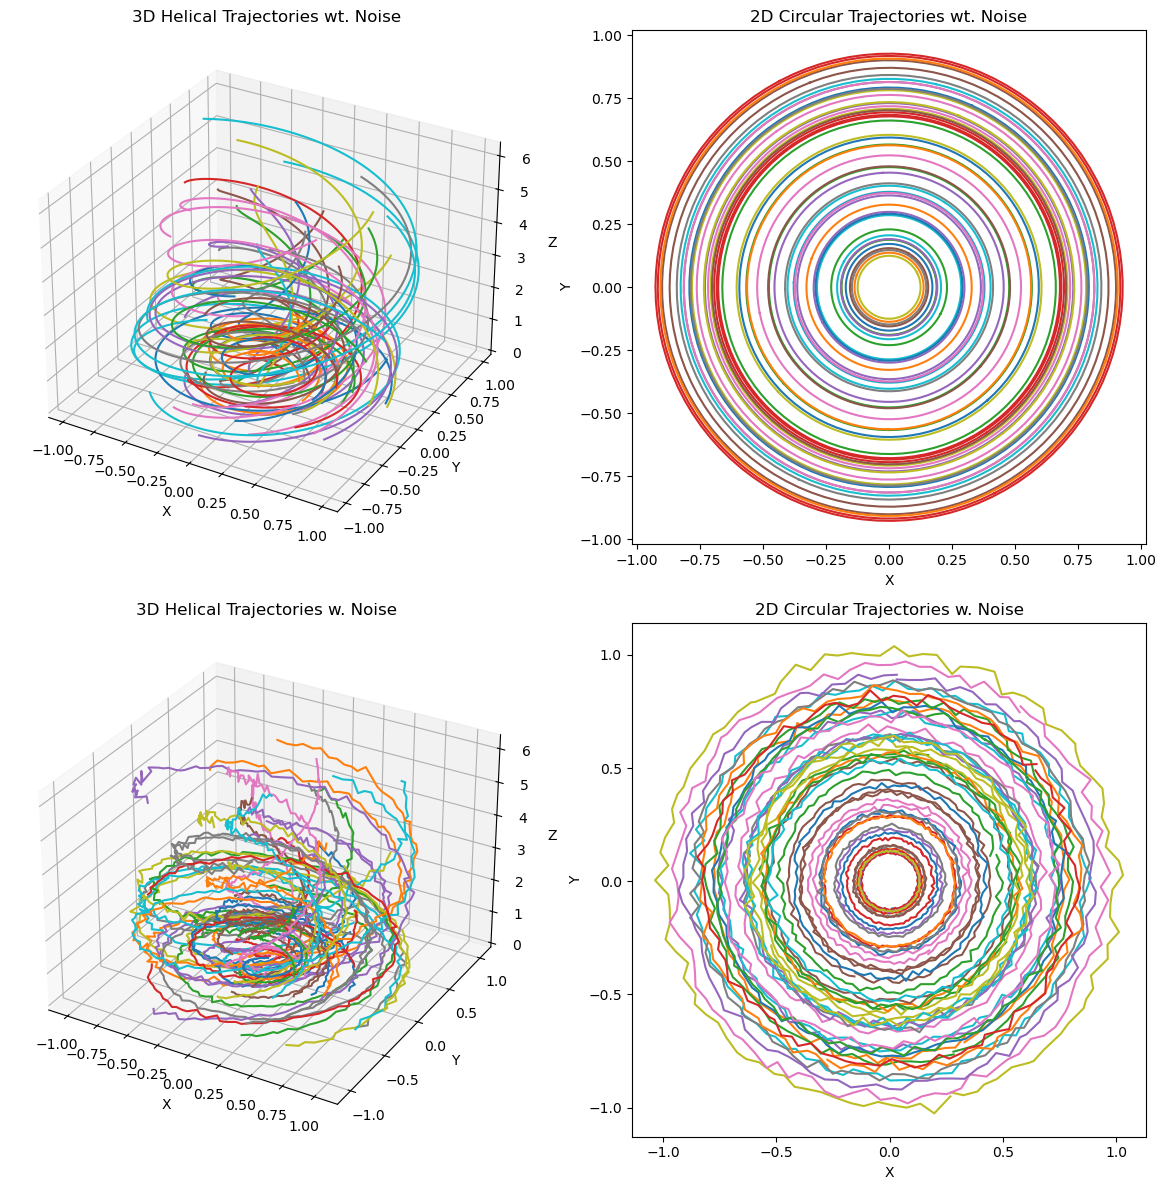

In [13]:
import matplotlib.pyplot as plt
# Generate trajectories
set_seed(58)

trajectories_3D, radii_phi_z_3D = generate_trajectories(num_samples=50, num_points=100, dim="3D", deviation=0)
trajectories_2D, radii_phi_z_2D = generate_trajectories(num_samples=50, num_points=100, dim="2D", deviation=0)
trajectories_3D_noisy, radii_phi_z_3D_noisy = generate_trajectories(num_samples=50, num_points=100, dim="3D", deviation=0.02)
trajectories_2D_noisy, radii_phi_z_2D_noisy = generate_trajectories(num_samples=50, num_points=100, dim="2D", deviation=0.02)


# Create a single figure with subplots
fig = plt.figure(figsize=(12, 12))

# 3D subplot
ax1 = fig.add_subplot(2, 2, 1, projection="3d")
for traj in trajectories_3D:
    ax1.plot(traj['x'], traj['y'], traj['z'])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Helical Trajectories wt. Noise')

# 2D subplot
ax2 = fig.add_subplot(2, 2, 2)
for traj in trajectories_2D:
    ax2.plot(traj['x'], traj['y'])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('2D Circular Trajectories wt. Noise')
ax2.set_aspect('equal', 'box')  # Keeps circles from looking like ellipses

# 3D subplot
ax1 = fig.add_subplot(2, 2, 3, projection="3d")
for traj in trajectories_3D_noisy:
    ax1.plot(traj['x'], traj['y'], traj['z'])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Helical Trajectories w. Noise')

# 2D subplot
ax2 = fig.add_subplot(2, 2, 4)
for traj in trajectories_2D_noisy:
    ax2.plot(traj['x'], traj['y'])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('2D Circular Trajectories w. Noise')
ax2.set_aspect('equal', 'box')  # Keeps circles from looking like ellipses

# Adjust layout and show
plt.tight_layout()
plt.show()

**Loss function:**

Below figures a plot of the loss function for 1000 samples for the circular 2D and with 30 epochs. 

We notice a very fast convergence of the loss function for the non-noisy trajectories but as expected, a longer convergence time for the noisy trajectories. I am aware the code is super efficiently written, just wanted to show some quick results of loss-function behaviour. As expected, since 3D data has one more dimension, the noise is larger than that of 2D trajectories. So the error begins larger but eventually converges. 

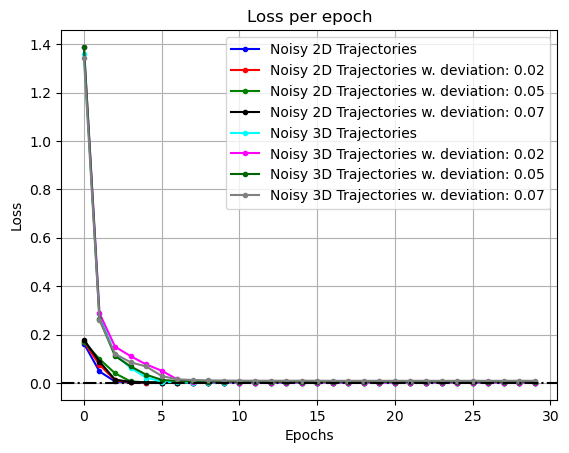

In [27]:
set_seed(58)
epochs, losses, dataset, model, deviation_1 = train_model(num_samples=1000, num_points=100, dim= "2D", epochs=30, deviation=0)
epochs_noise, losses_noise, dataset_noise, model_noise, deviation_noise = train_model(num_samples=1000, num_points=100, dim="2D", epochs=30, deviation=0.02)
epochs_noise2, losses_noise2, dataset_noise2, model_noise2, deviation_noise2 = train_model(num_samples=1000, num_points=100, dim="2D", epochs=30, deviation=0.05)
epochs_noise3, losses_noise3, dataset_noise3, model_noise3, deviation_noise3 = train_model(num_samples=1000, num_points=100, dim="2D", epochs=30, deviation=0.07)

epochs_3d, losses_3d, dataset, model, deviation_1_3d = train_model(num_samples=1000, num_points=100, dim= "3D", epochs=30, deviation=0)
epochs_noise_3d, losses_noise_3d, dataset_noise, model_noise, deviation_noise_3d = train_model(num_samples=1000, num_points=100, dim="3D", epochs=30, deviation=0.02)
epochs_noise2_3d, losses_noise2_3d, dataset_noise2, model_noise2, deviation_noise2_3d = train_model(num_samples=1000, num_points=100, dim="3D", epochs=30, deviation=0.05)
epochs_noise3_3d, losses_noise3_3d, dataset_noise3, model_noise3, deviation_noise3_3d = train_model(num_samples=1000, num_points=100, dim="3D", epochs=30, deviation=0.07)
plt.figure()
plt.plot(epochs, losses, color='blue', marker=".", label="Noisy 2D Trajectories" )
plt.plot(epochs_noise, losses_noise, color='red', marker=".", label=f"Noisy 2D Trajectories w. deviation: {deviation_noise}" )
plt.plot(epochs_noise2, losses_noise2, color='green', marker=".", label=f"Noisy 2D Trajectories w. deviation: {deviation_noise2}" )
plt.plot(epochs_noise3, losses_noise3, color='black', marker=".", label=f"Noisy 2D Trajectories w. deviation: {deviation_noise3}" )
plt.plot(epochs, losses_3d, color='cyan', marker=".", label="Noisy 3D Trajectories" )
plt.plot(epochs_noise_3d, losses_noise_3d, color='magenta', marker=".", label=f"Noisy 3D Trajectories w. deviation: {deviation_noise_3d}" )
plt.plot(epochs_noise2_3d, losses_noise2_3d, color='darkgreen', marker=".", label=f"Noisy 3D Trajectories w. deviation: {deviation_noise2_3d}" )
plt.plot(epochs_noise3_3d, losses_noise3_3d, color='grey', marker=".", label=f"Noisy 3D Trajectories w. deviation: {deviation_noise3_3d}")
plt.axhline(y=0, color='black', linestyle="-.")
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per epoch")
plt.show()

**2D Plots of Trajectories and Neural Network Reconstructions:**

In the giant plot below, I've tried to show what happens for different sample sizes and points (resolution) of trajectories. 

The latent space shows some things we can recognize - for instance the trajectories are only generated above 0.1 , so we see a "wall" at 0.1. In larger sample size this manifests itself as a hole inside the latent space plot. I chose to use the radii for colormapping which slows how the NN encodes the data by the ordering of the smallest radii first to the largest!

Super curiously, some of the reconstructions are just simply cursed - it's like that specific sample just didn't work good through our AE - but I'm not sure why that is. Maybe it's just the way the AE is trained and optimizing hyperparameters. 

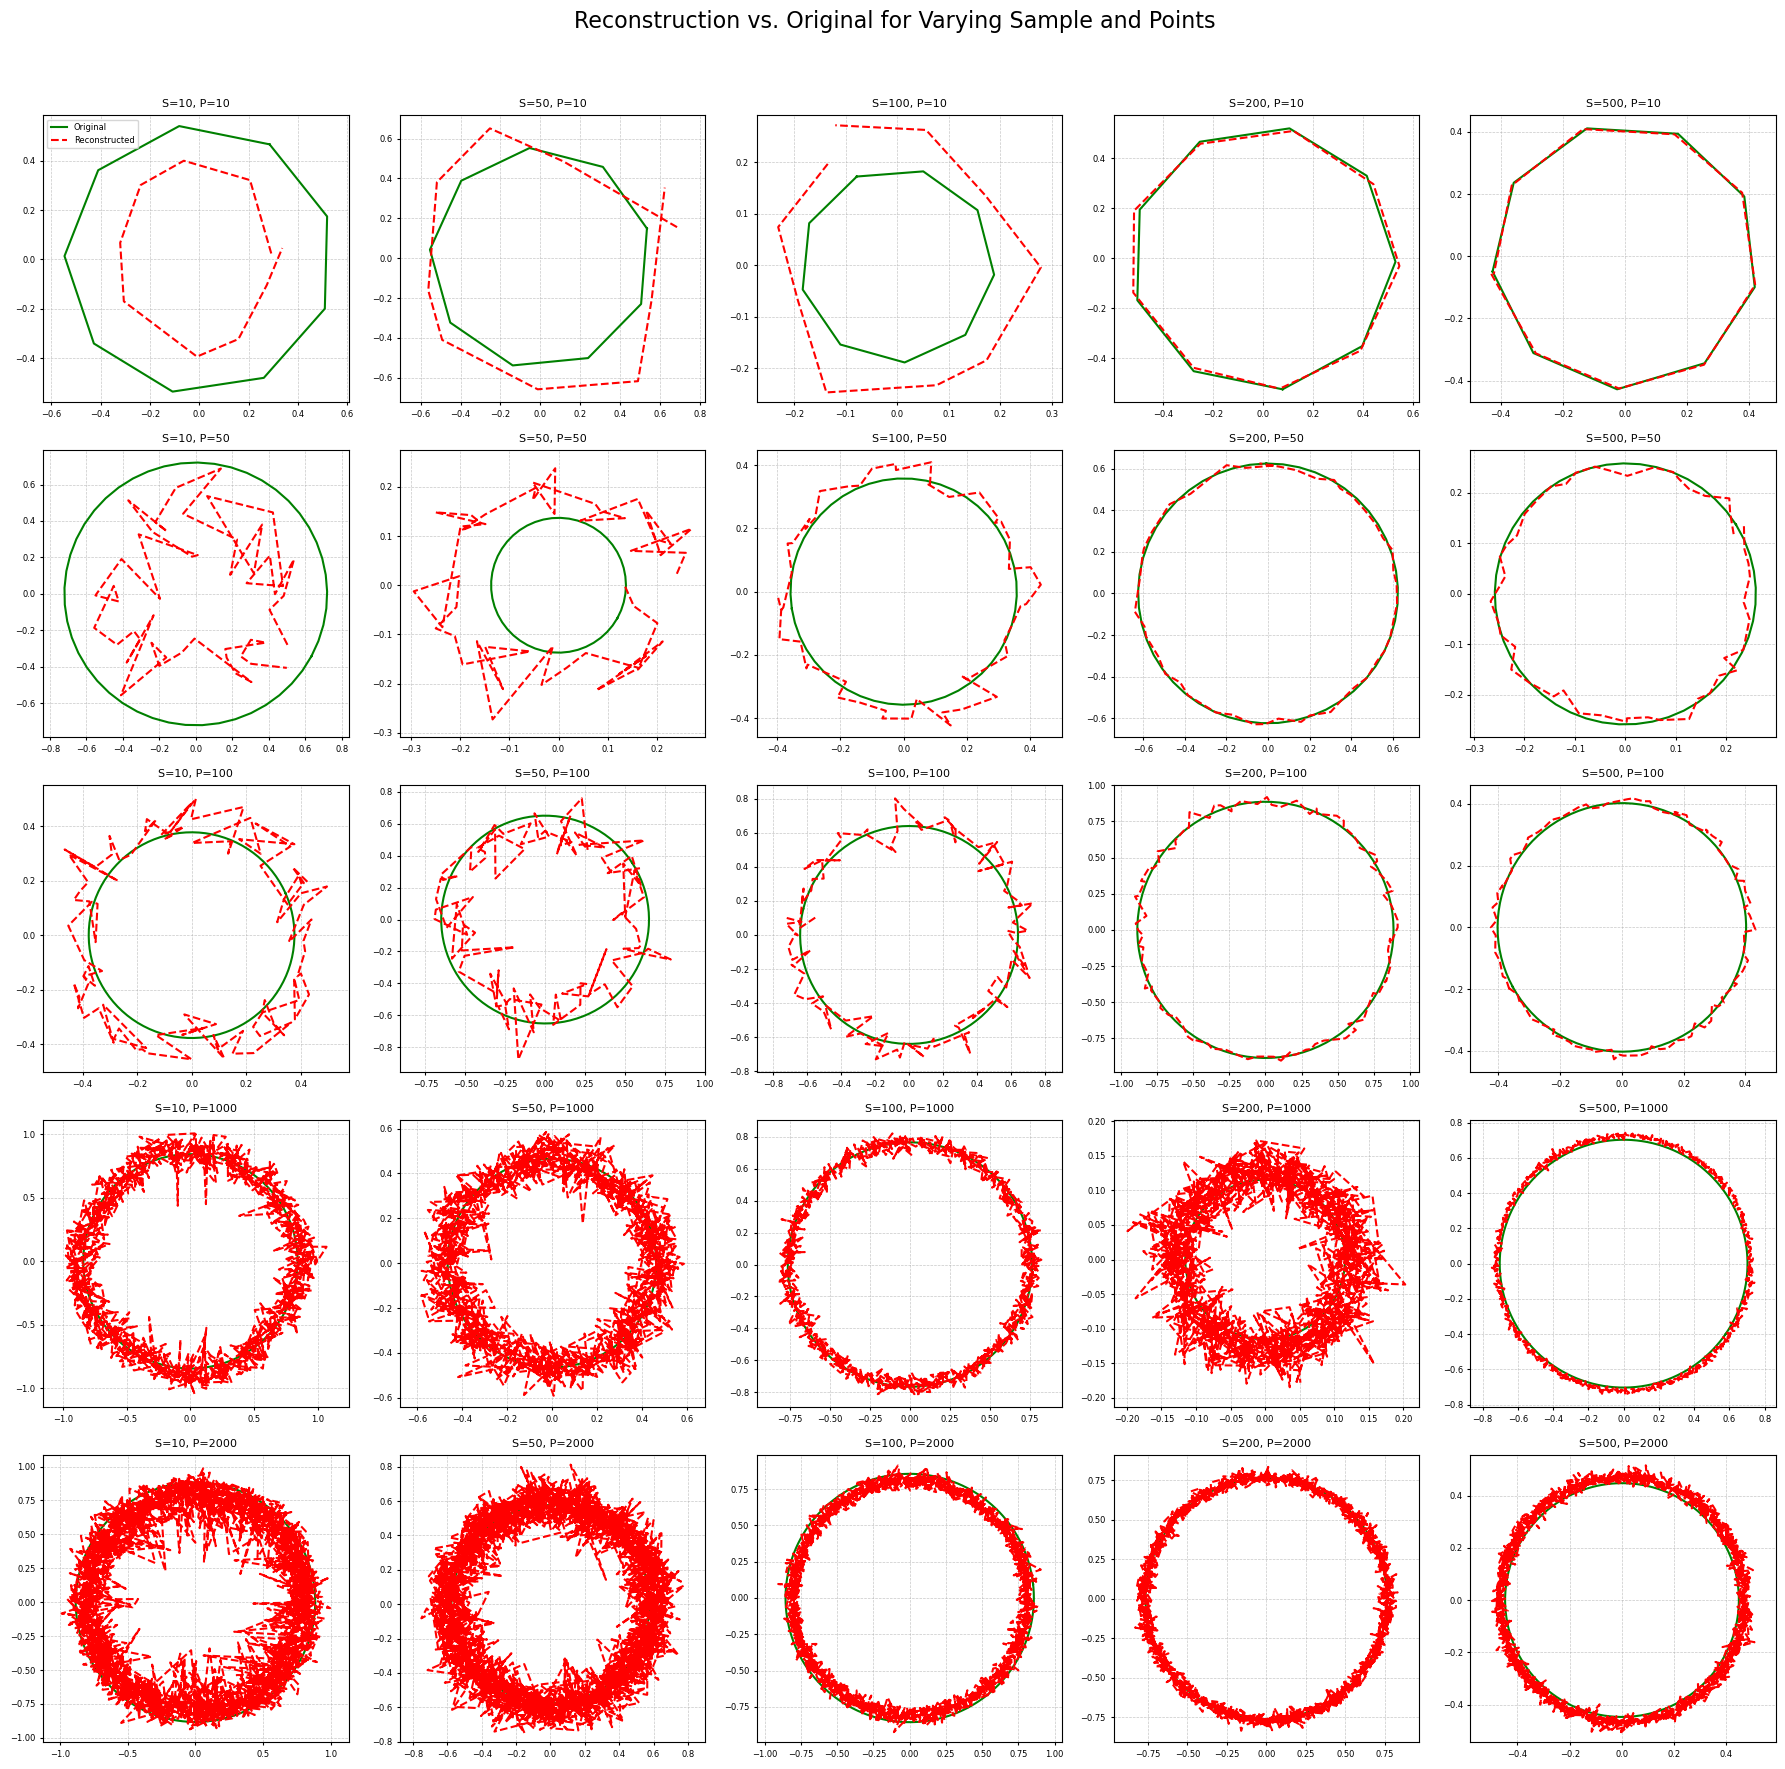

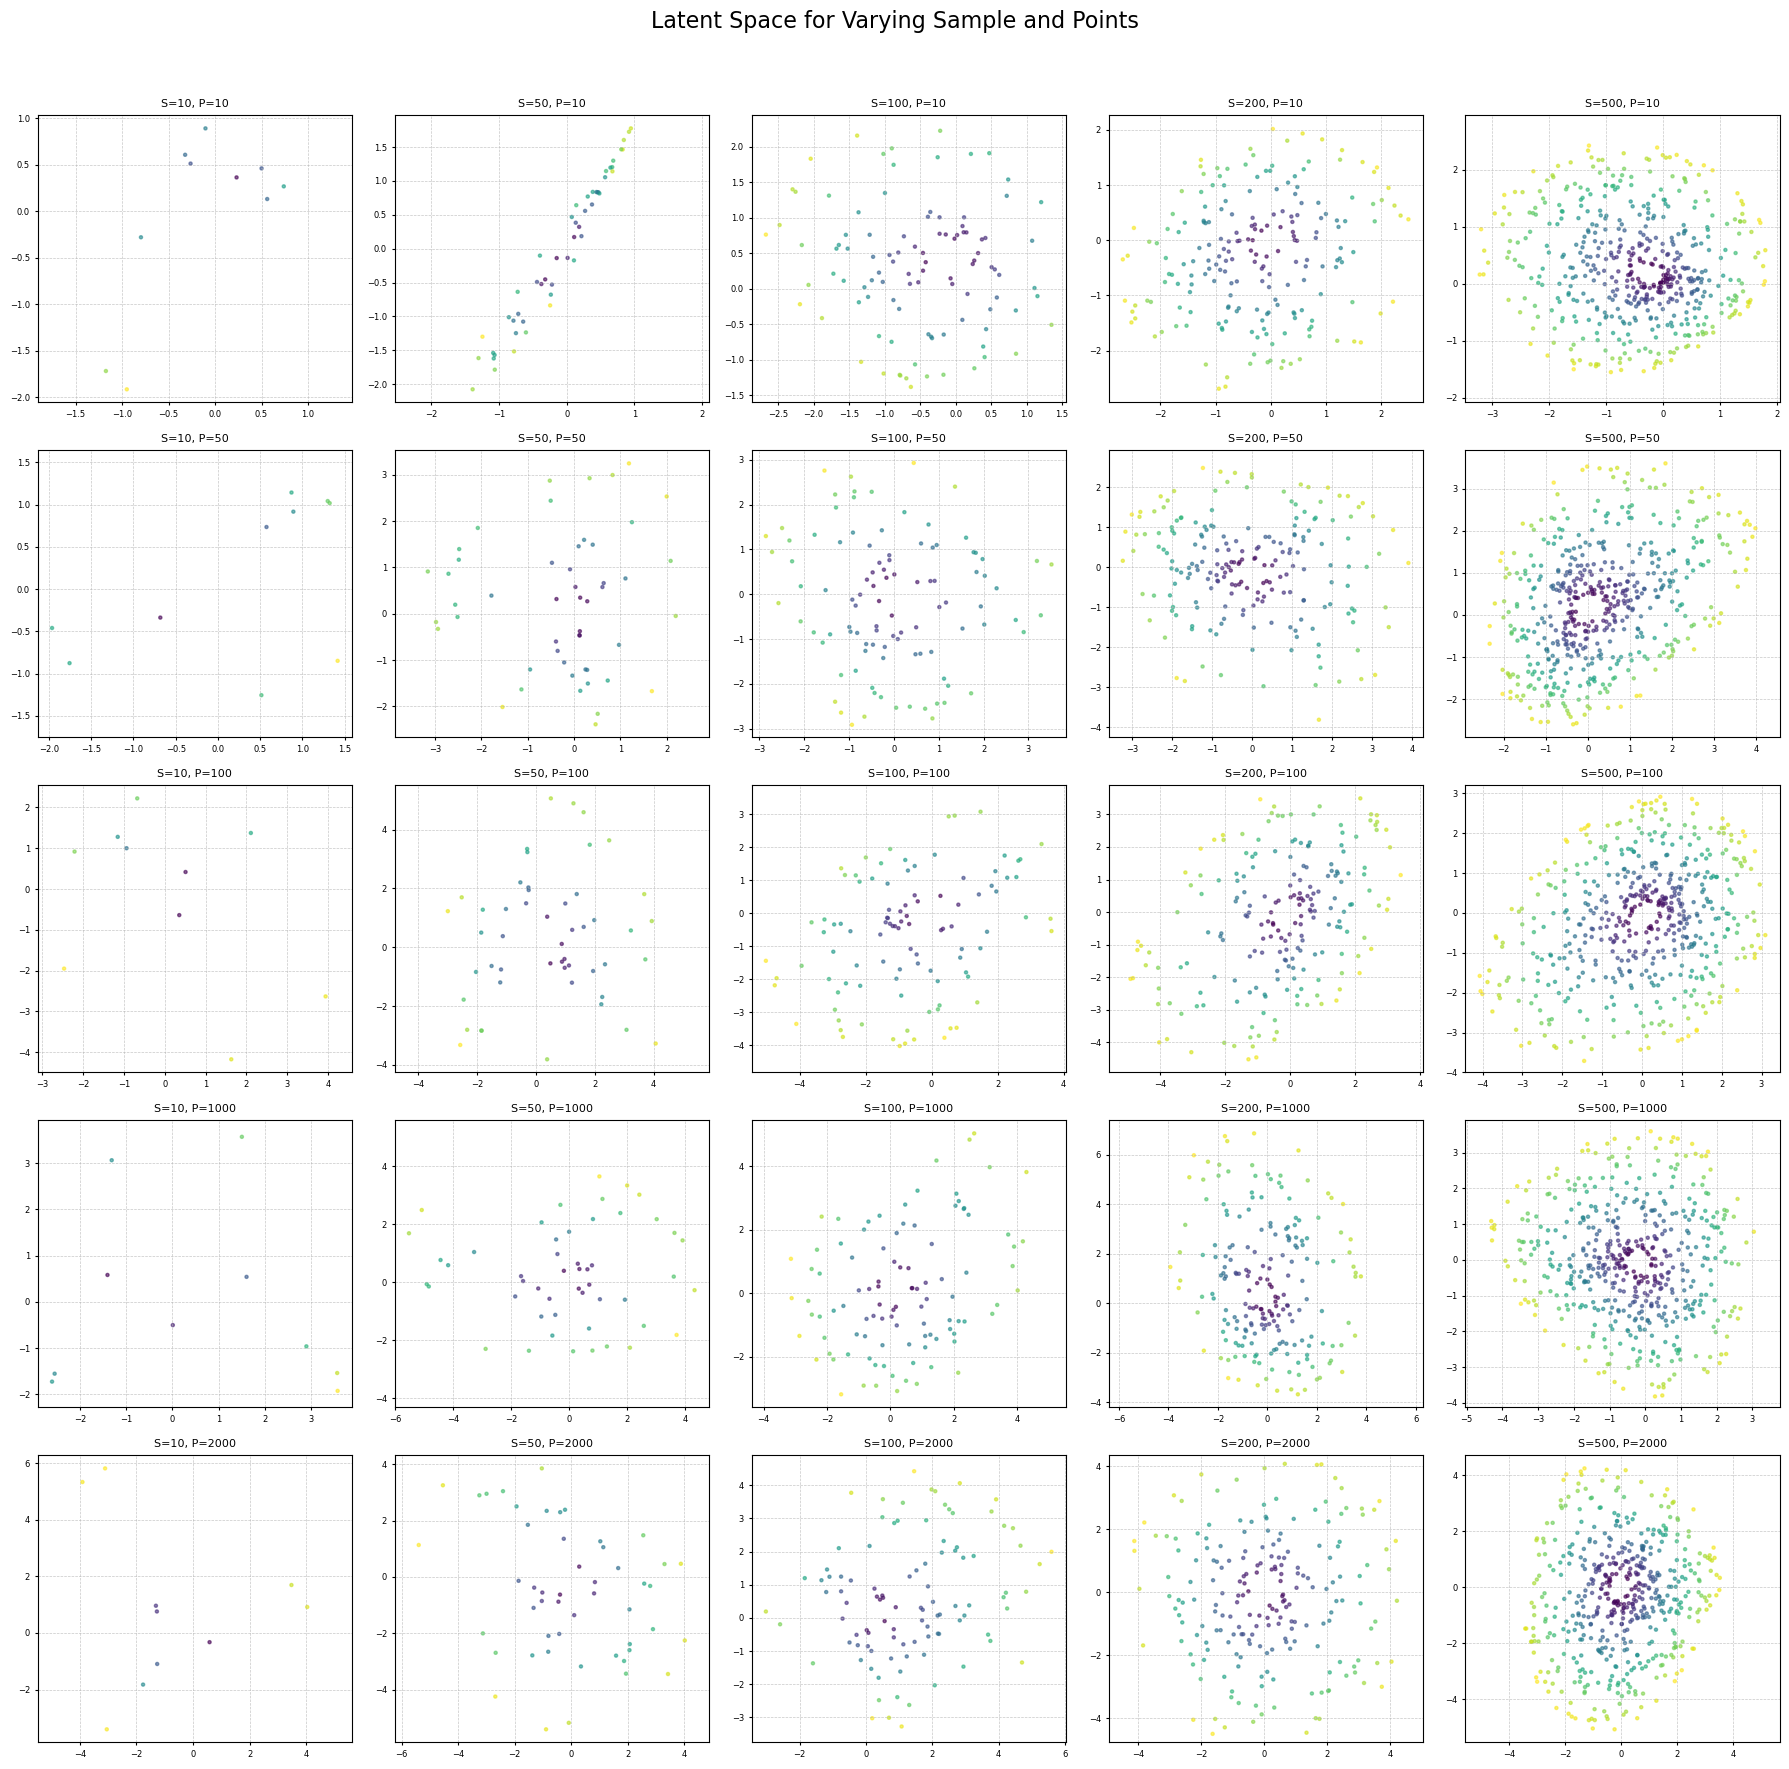

In [33]:
# Array over which we iterate
S = np.array([10, 50, 100, 200, 500]) # S for number of Samples
P = np.array([10, 50, 100, 1000, 2000]) # P for number of Points

index = 2 # Random trajectory selected in 

set_seed(58)

# Initialize plots
fig = plt.figure(figsize=(18, 18))
fig2 = plt.figure(figsize=(18, 18))

for j in range(len(P)):
    for i in range(len(S)):
        num_samples=S[i]
        num_points=P[j]
        dim="2D"
        epochs=30
        epochs, losses, dataset, model, deviation0 = train_model(num_samples, num_points, dim, epochs, deviation=0)
        
        with torch.no_grad():
            full_data = dataset.flat_data[:]
            _, latents = model(full_data)

        latents_array = latents.numpy()

        with torch.no_grad():
            samples = full_data[index]
            reconstructions, _ = model(samples)

        original = samples.reshape(-1, 2).numpy()
        recovered = reconstructions.reshape(-1, 2).numpy()
        

        subplot_index = j * len(S) + i + 1

        # Trajectories Plot
        ax = fig.add_subplot(len(P), len(S), subplot_index)
        ax.plot(original[:, 0], original[:, 1], label="Original", color='green')
        ax.plot(recovered[:, 0], recovered[:, 1], '--', label="Reconstructed", color='red')
        ax.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax.axis("equal")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.tick_params(labelsize=6, length=2)
        if j == 0 and i == 0:
            ax.legend(fontsize=6)

        # Latent Space Plot
        ax2 = fig2.add_subplot(len(P), len(S), subplot_index)
        plt.scatter(latents_array[:, 0], latents_array[:, 1], marker='o', s=5, alpha=0.6, c=dataset.radii_phi_z[:,0], cmap='viridis' )
        ax2.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax2.axis("equal")
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.tick_params(labelsize=6, length=2)
    

fig.suptitle("Reconstruction vs. Original for Varying Sample and Points", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])

fig2.suptitle("Latent Space for Varying Sample and Points", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


**3D Plots of Trajectories and Neural Network Reconstructions:**

In the giant plot below, I've tried to show what happens for different sample sizes and points (resolution) of trajectories. Similarly, smaller sample size affects heavily the behaviour of the data. And the less resolution can at times mean better reconstruction.

The latent space shows an interesting ordering - I have chosen to colormap it according to the radii of the trajectory. This causes the points to be ordered in a way that is somewhat intuitive - the points that are closer to the origin are the ones safd

KeyboardInterrupt: 

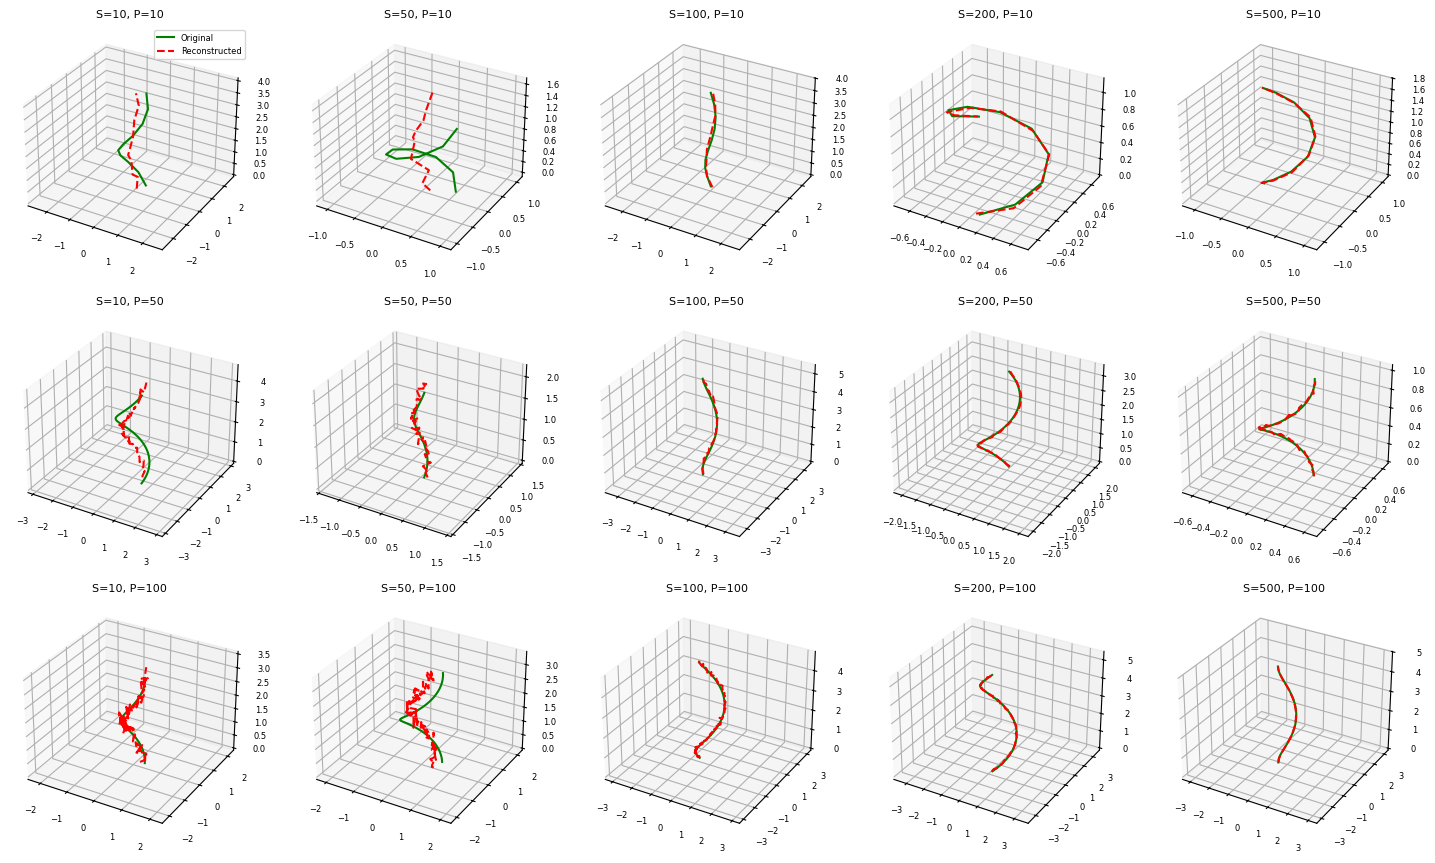

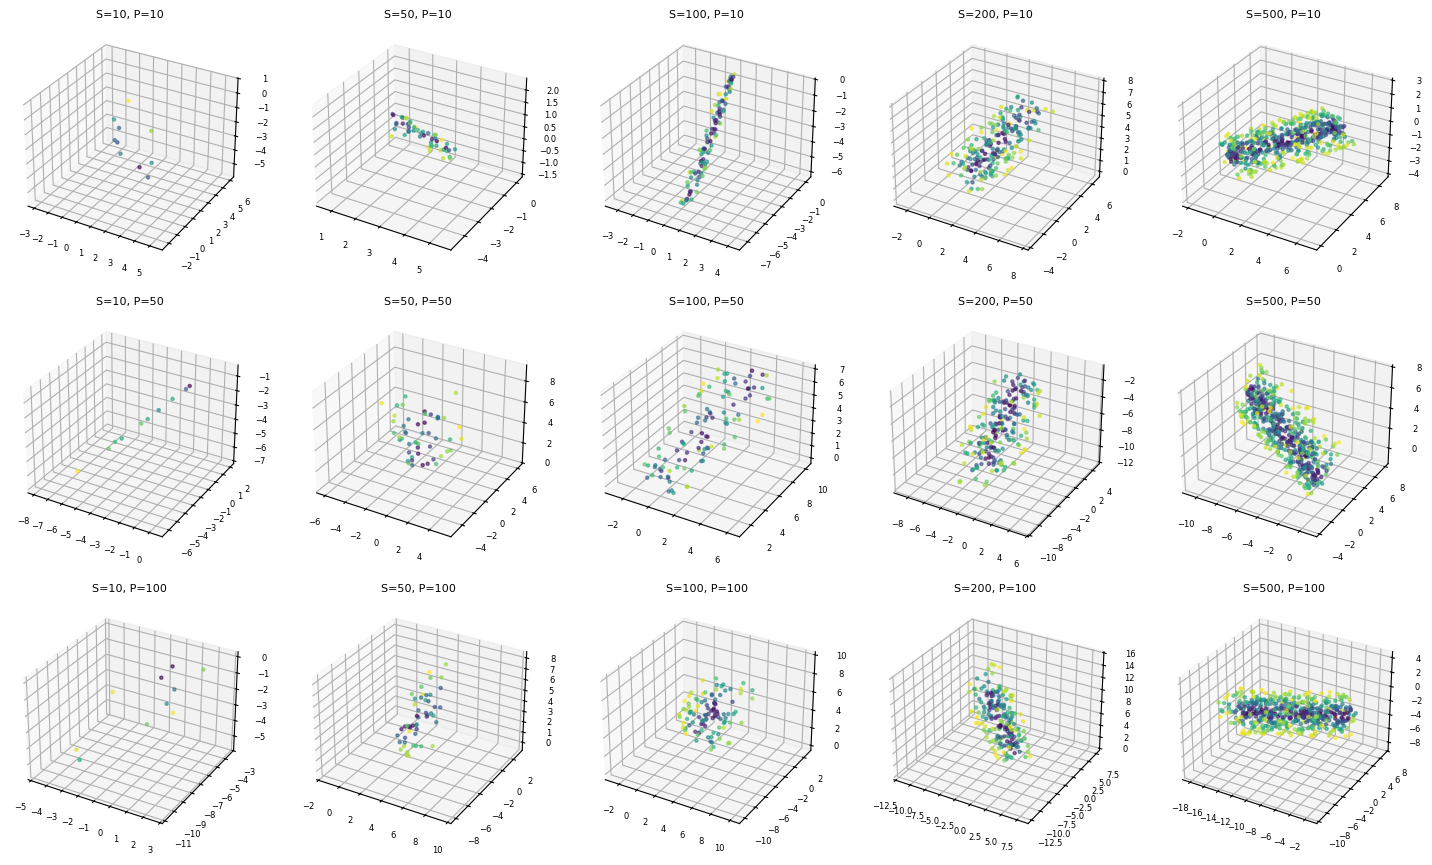

In [ ]:
S = np.array([10, 50, 100, 200, 500])
P = np.array([10, 50, 100, 1000, 2000])

index = 2

set_seed(58)

fig = plt.figure(figsize=(18, 18))
fig2 = plt.figure(figsize=(18, 18))

for j in range(len(P)):
    for i in range(len(S)):
        num_samples=S[i]
        num_points=P[j]
        dim="3D"
        epochs=50
        epochs1, losses, dataset, model, deviation1 = train_model(num_samples, num_points, dim, epochs, deviation=0)
        
        with torch.no_grad():
            full_data = dataset.flat_data[:]
            _, latents = model(full_data)

        latents_array = latents.numpy()

        with torch.no_grad():
            samples = full_data[index]
            reconstructions, _ = model(samples)

        original = samples.reshape(-1, 3).numpy()
        recovered = reconstructions.reshape(-1, 3).numpy()
        
        subplot_index = j * len(S) + i + 1

        # Trajectories Plot
        ax = fig.add_subplot(len(P), len(S), subplot_index, projection = "3d")
        ax.plot(original[:, 0], original[:, 1], original[:, 2], label="Original", color='green')
        ax.plot(recovered[:, 0], recovered[:, 1], recovered[:, 2], '--', label="Reconstructed", color='red')
        ax.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax.axis("equal")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.tick_params(labelsize=6, length=2)
        if j == 0 and i == 0:
            ax.legend(fontsize=6)

        # Latent Space Plot
        ax2 = fig2.add_subplot(len(P), len(S), subplot_index, projection="3d")
        ax2.scatter(latents_array[:, 0], latents_array[:, 1], latents_array[:, 2], s=5, alpha=0.6, c=dataset.radii_phi_z[:,0], cmap='viridis')
        ax2.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax2.axis("equal")
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.tick_params(labelsize=6, length=2)
    

fig.suptitle(f"Reconstruction vs. Original for Varying Sample and Points for {epochs} epochs", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])

fig2.suptitle(f"Latent Space for Varying Sample and Points for {epochs} epochs", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

**2D Plots of Trajectories and Neural Network Reconstructions with Gaussian Noise:**

In the big plot below we see the behaviour of noisy data when the std. deviation is set to 0.03 - the NN still manages to learn some circles properly and even surconvent the noise to some extent. This happens again mostly for large sample sizes. The latent space structure is also quite similaer which indicates, that noise doesn't make a huge difference in the latent space structure.

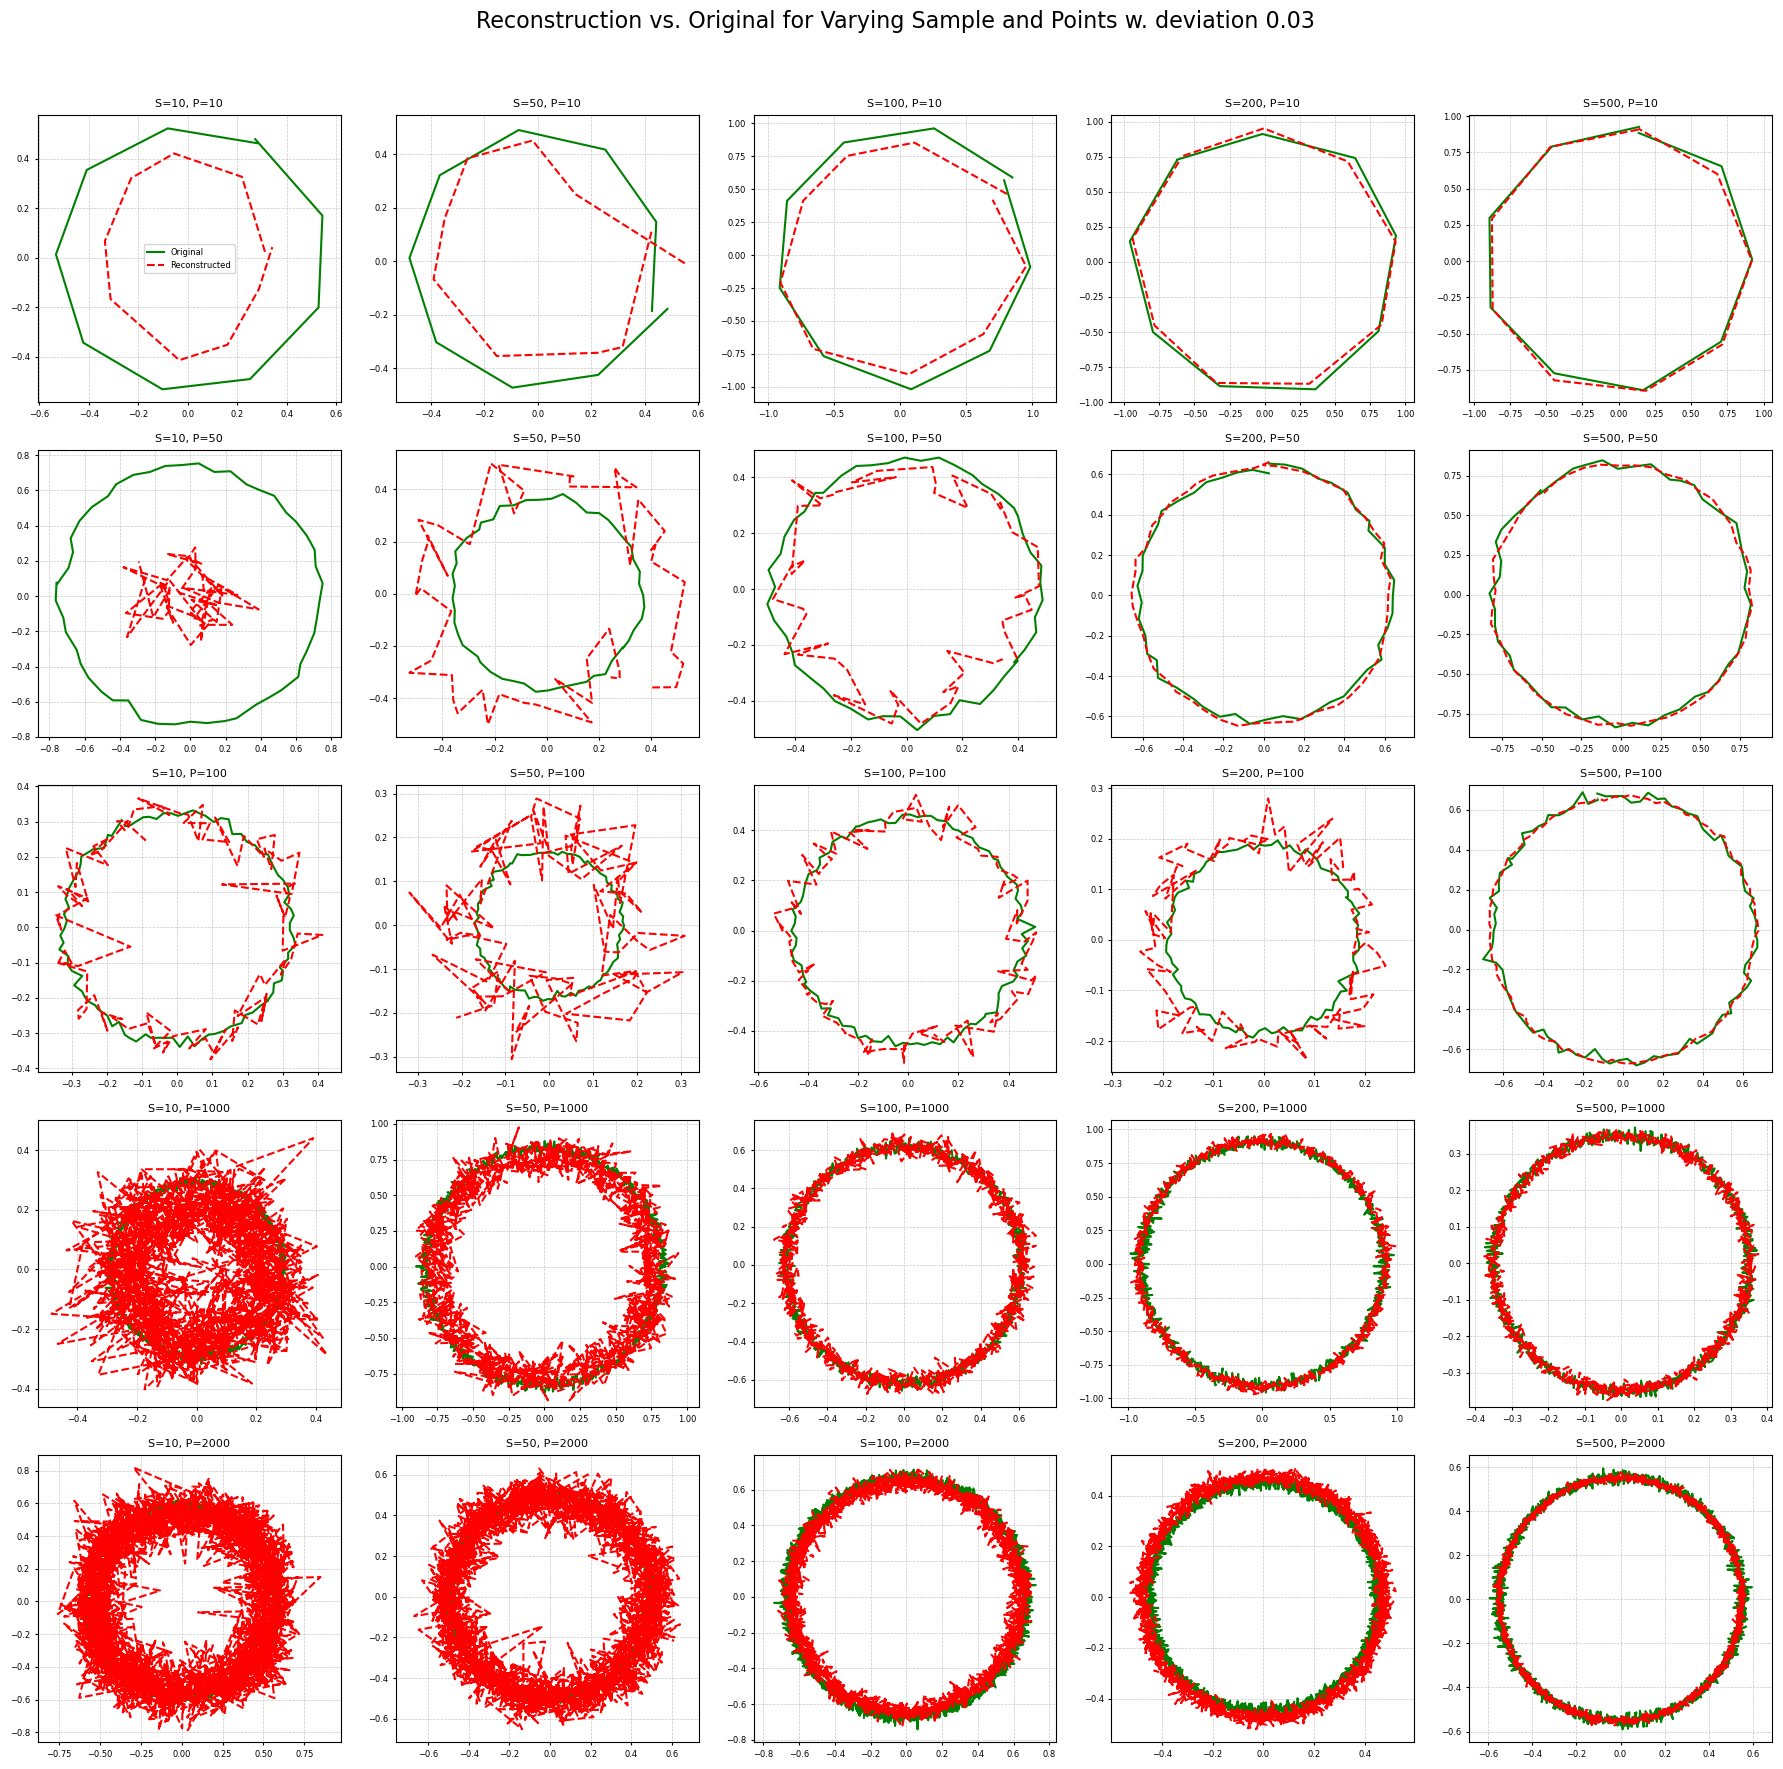

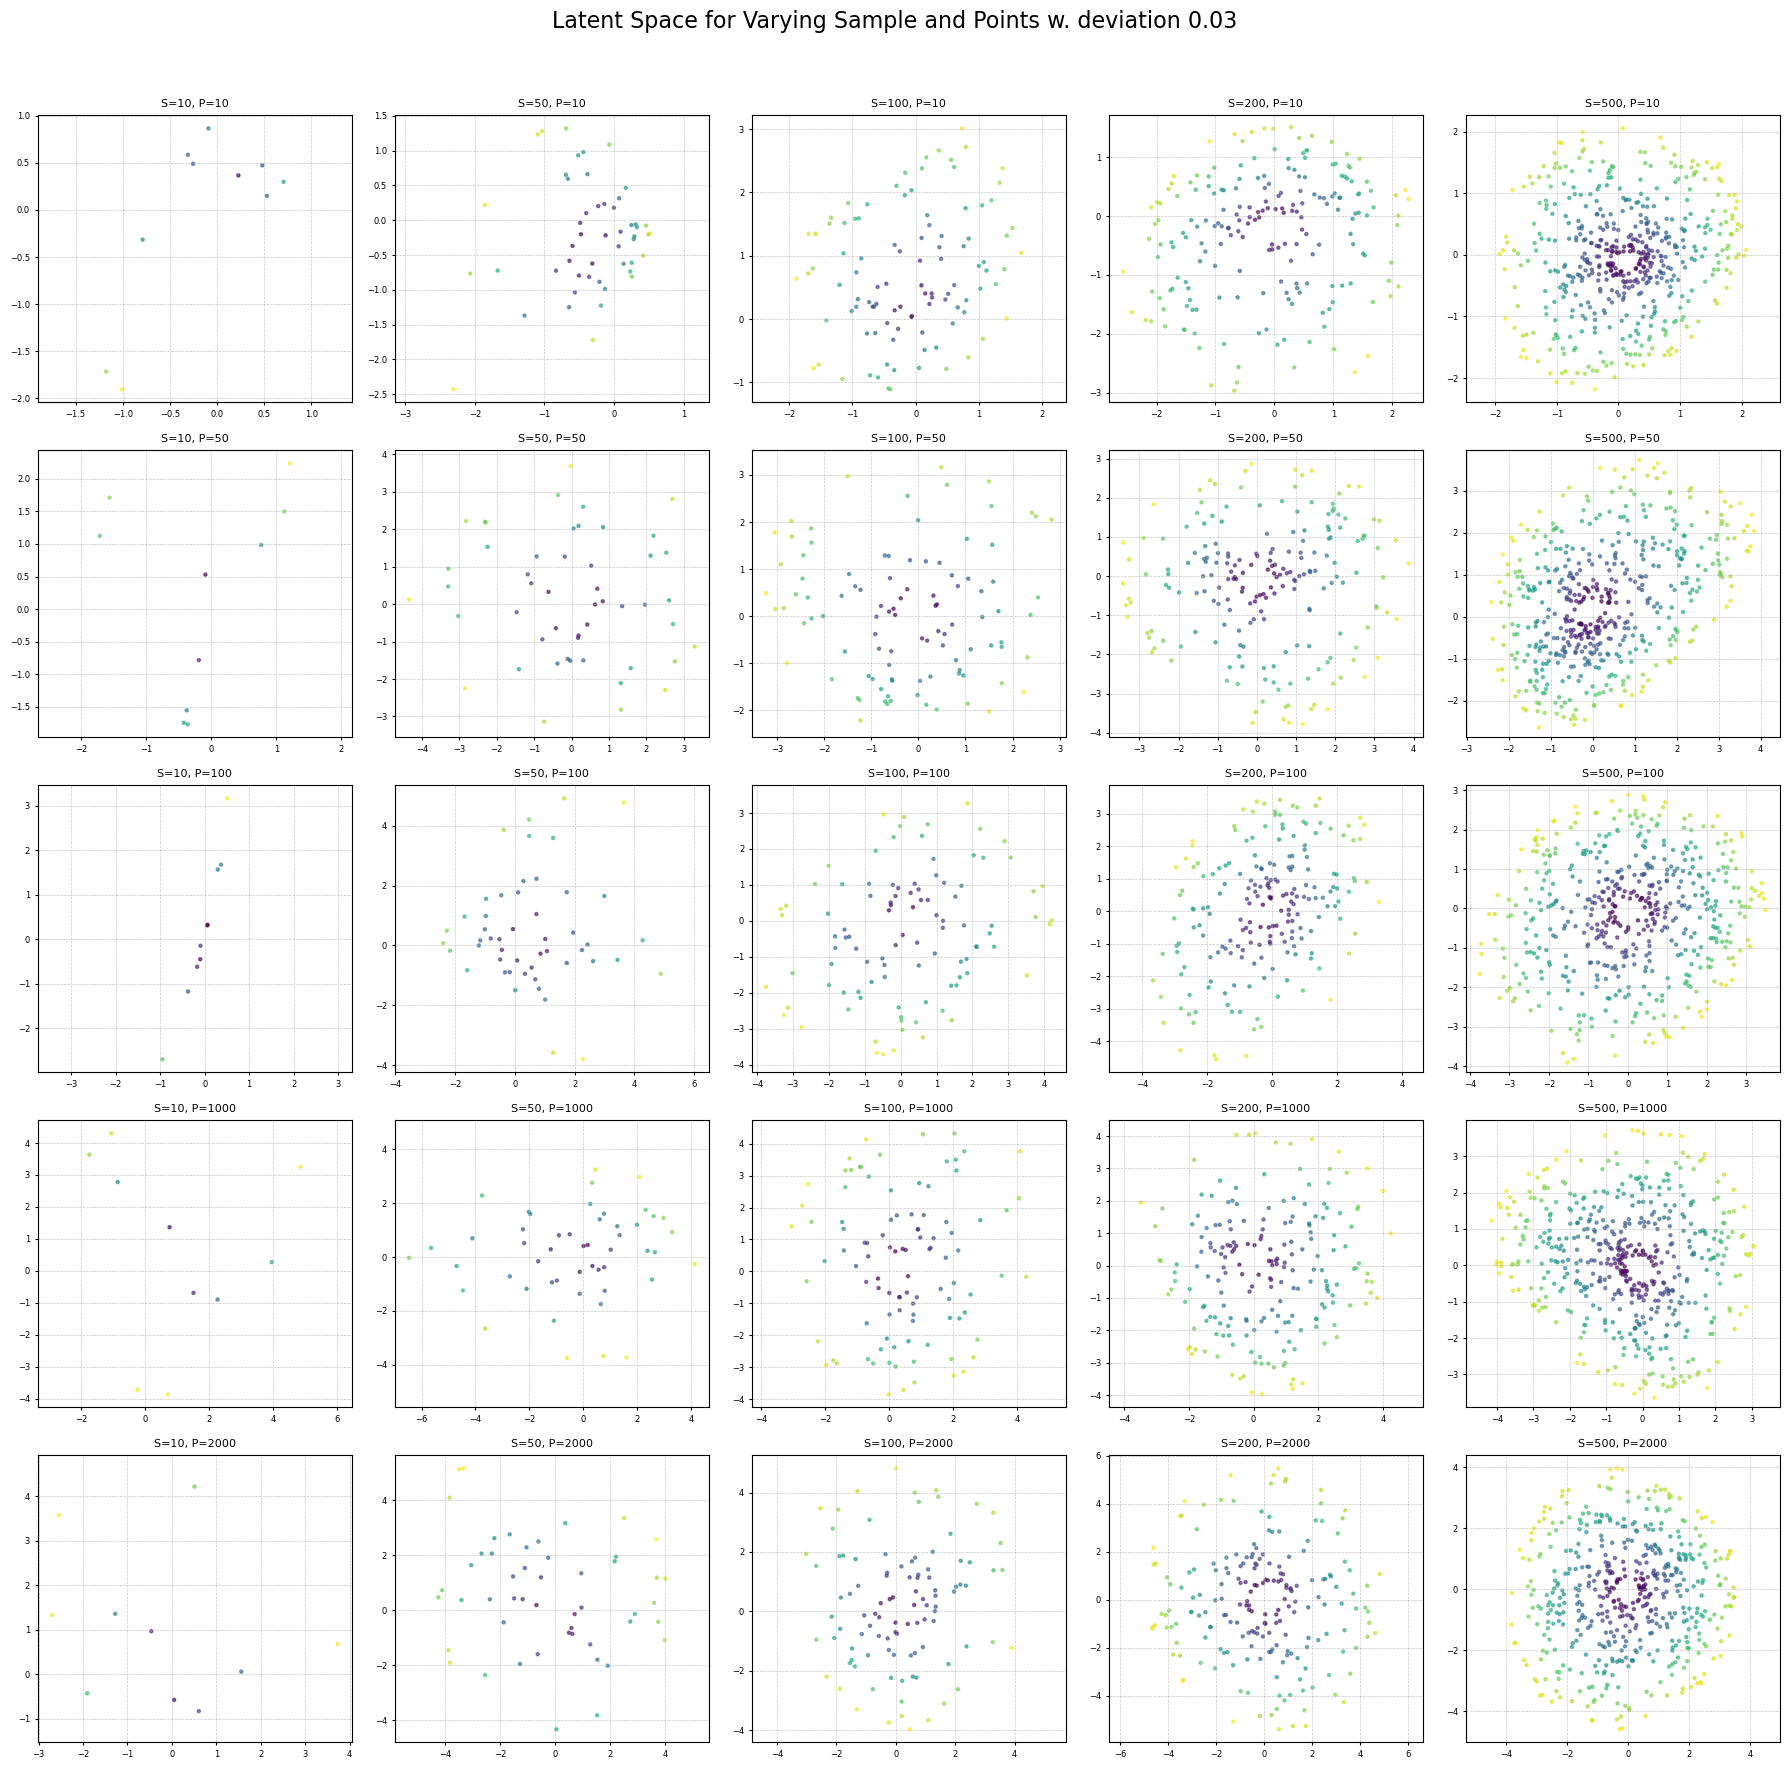

In [35]:
# Array over which we iterate
S = np.array([10, 50, 100, 200, 500]) # S for number of Samples
P = np.array([10, 50, 100, 1000, 2000]) # P for number of Points

index = 2 # Random trajectory selected in 

set_seed(58)

# Initialize plots
fig = plt.figure(figsize=(18, 18))
fig2 = plt.figure(figsize=(18, 18))

for j in range(len(P)):
    for i in range(len(S)):
        num_samples=S[i]
        num_points=P[j]
        dim="2D"
        epochs=30
        epochs, losses, dataset, model, deviation1 = train_model(num_samples, num_points, dim, epochs, deviation = 0.03)
        
        with torch.no_grad():
            full_data = dataset.flat_data[:]
            _, latents = model(full_data)

        latents_array = latents.numpy()

        with torch.no_grad():
            samples = full_data[index]
            reconstructions, _ = model(samples)

        original = samples.reshape(-1, 2).numpy()
        recovered = reconstructions.reshape(-1, 2).numpy()
        

        subplot_index = j * len(S) + i + 1

        # Trajectories Plot
        ax = fig.add_subplot(len(P), len(S), subplot_index)
        ax.plot(original[:, 0], original[:, 1], label="Original", color='green')
        ax.plot(recovered[:, 0], recovered[:, 1], '--', label="Reconstructed", color='red')
        ax.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax.axis("equal")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.tick_params(labelsize=6, length=2)
        if j == 0 and i == 0:
            ax.legend(fontsize=6)

        # Latent Space Plot
        ax2 = fig2.add_subplot(len(P), len(S), subplot_index)
        plt.scatter(latents_array[:, 0], latents_array[:, 1], marker='o', s=5, alpha=0.6, c=dataset.radii_phi_z[:,0], cmap='viridis' )
        ax2.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax2.axis("equal")
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.tick_params(labelsize=6, length=2)
    

fig.suptitle(f"Reconstruction vs. Original for Varying Sample and Points w. deviation {deviation1}", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])

fig2.suptitle(f"Latent Space for Varying Sample and Points w. deviation {deviation1}", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


**3D Plots of Trajectories and Neural Network Reconstructions with Gaussian Noise:**

In the big plot below we see the behaviour of noisy data when the std. deviation is set to 0.03. 
Surprisingly, even with noise in 3D space which is inherently larger because of the additional dimension, 

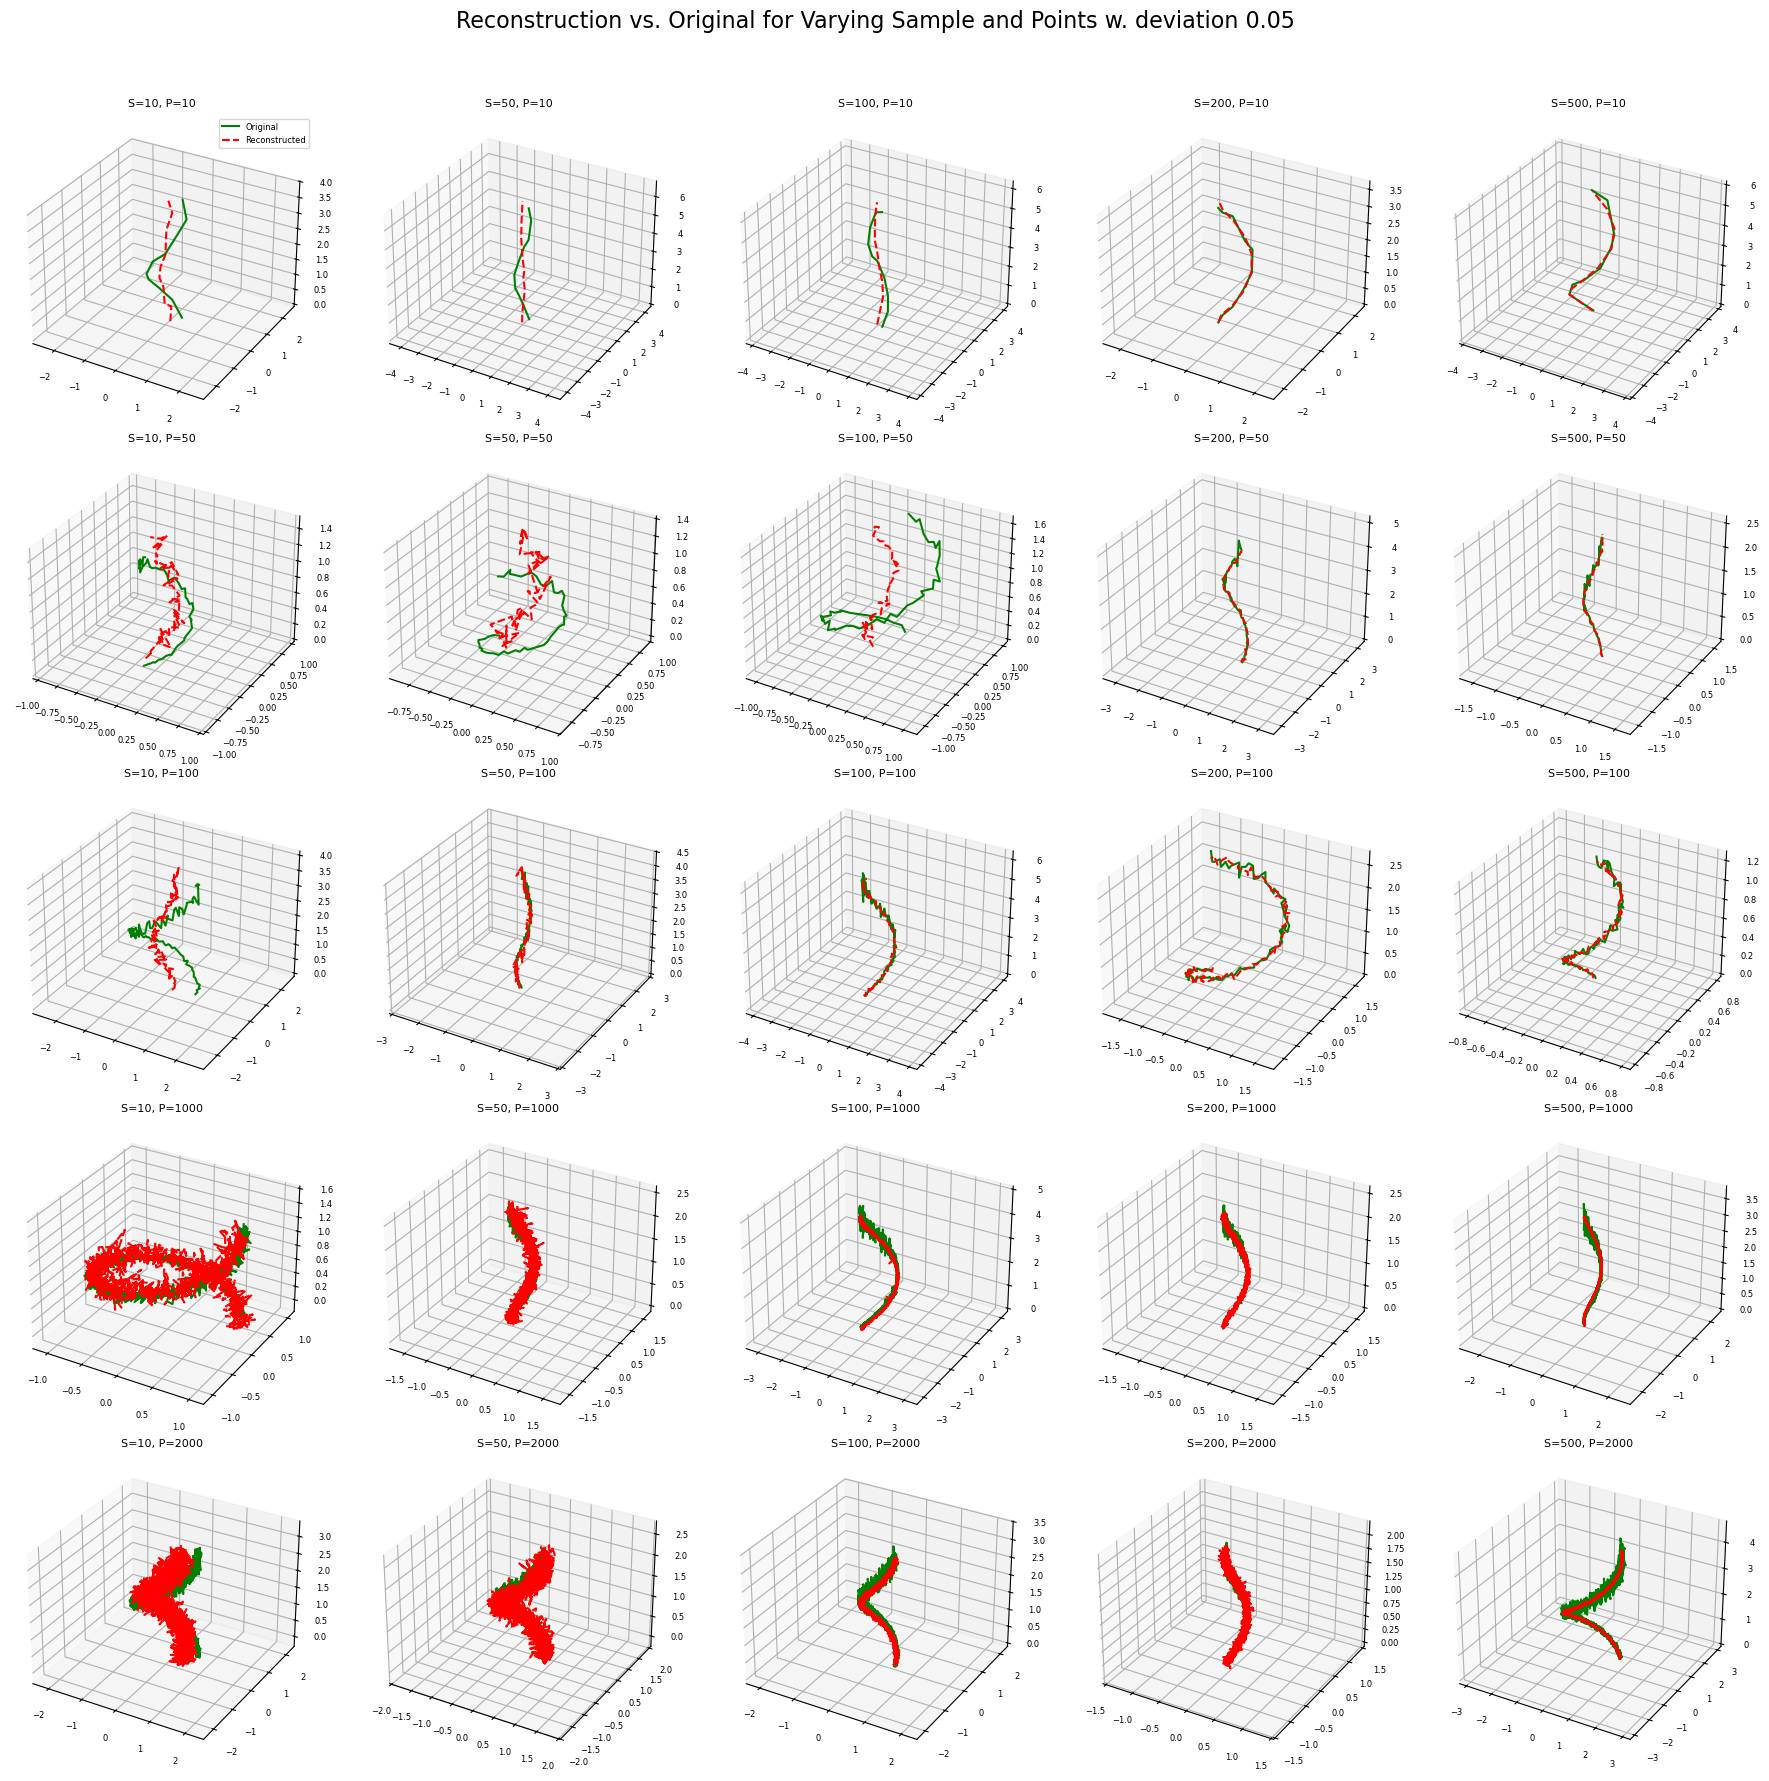

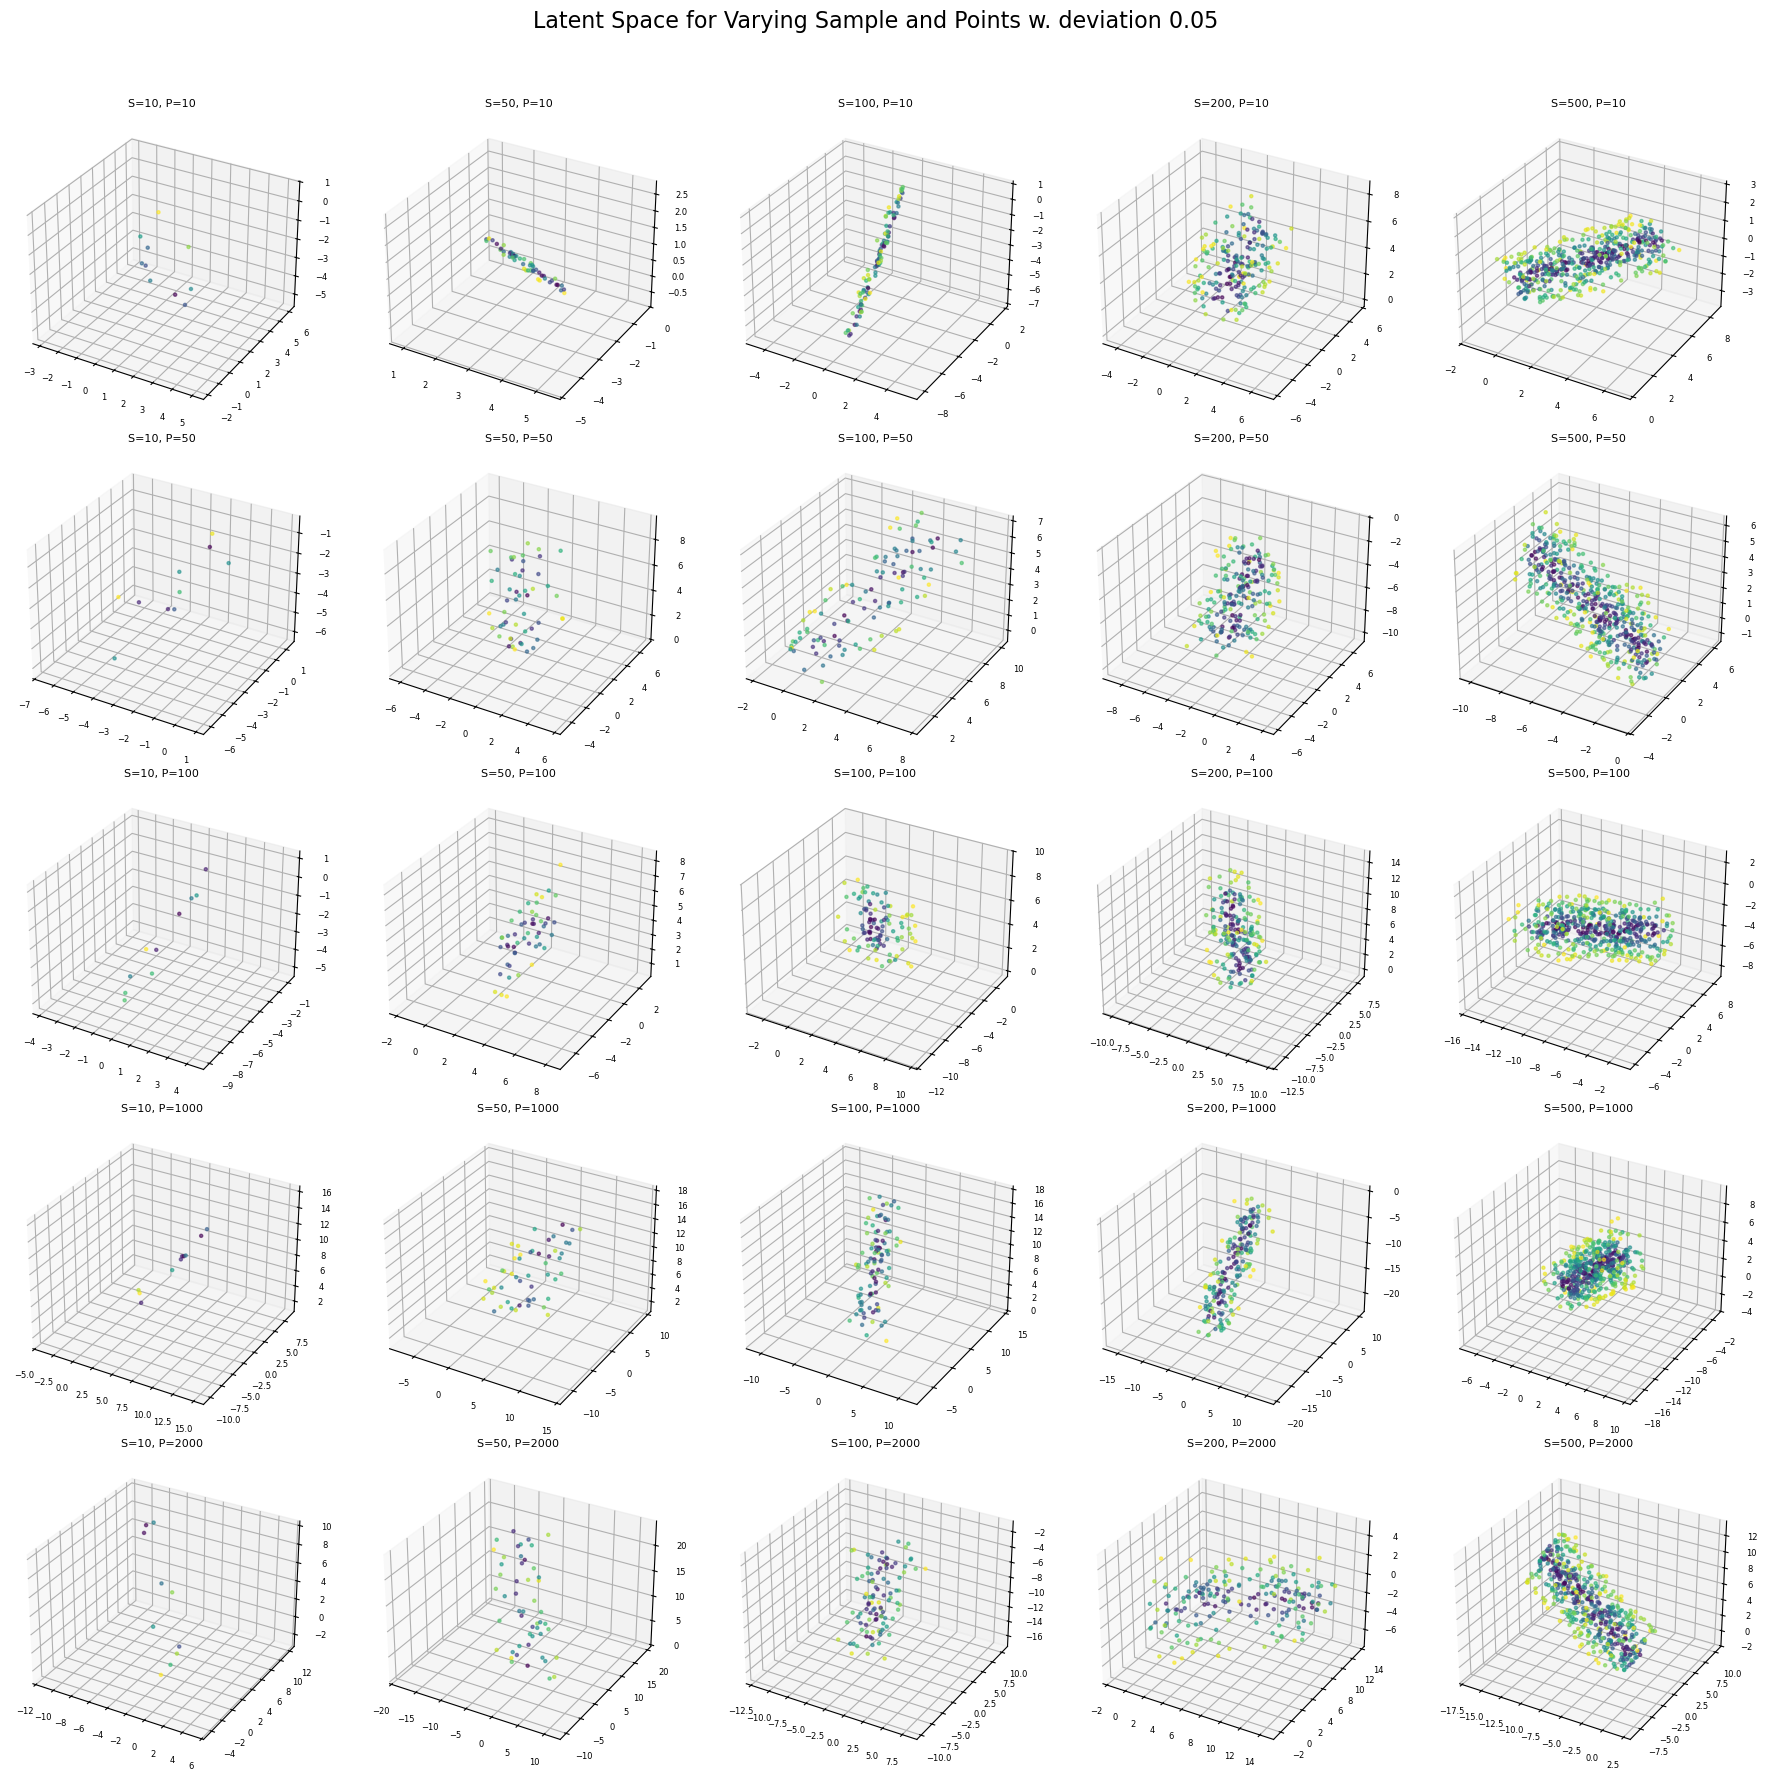

In [36]:
S = np.array([10, 50, 100, 200, 500])
P = np.array([10, 50, 100, 1000, 2000])

index = 2

set_seed(58)

fig = plt.figure(figsize=(18, 18))
fig2 = plt.figure(figsize=(18, 18))

for j in range(len(P)):
    for i in range(len(S)):
        num_samples=S[i]
        num_points=P[j]
        dim="3D"
        epochs=50
        epochs, losses, dataset, model, deviation1 = train_model(num_samples, num_points, dim, epochs, deviation = 0.05)
        
        with torch.no_grad():
            full_data = dataset.flat_data[:]
            _, latents = model(full_data)

        latents_array = latents.numpy()

        with torch.no_grad():
            samples = full_data[index]
            reconstructions, _ = model(samples)

        original = samples.reshape(-1, 3).numpy()
        recovered = reconstructions.reshape(-1, 3).numpy()
        
        subplot_index = j * len(S) + i + 1

        # Trajectories Plot
        ax = fig.add_subplot(len(P), len(S), subplot_index, projection = "3d")
        ax.plot(original[:, 0], original[:, 1], original[:, 2], label="Original", color='green')
        ax.plot(recovered[:, 0], recovered[:, 1], recovered[:, 2], '--', label="Reconstructed", color='red')
        ax.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax.axis("equal")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.tick_params(labelsize=6, length=2)
        if j == 0 and i == 0:
            ax.legend(fontsize=6)

        # Latent Space Plot
        ax2 = fig2.add_subplot(len(P), len(S), subplot_index, projection="3d")
        ax2.scatter(latents_array[:, 0], latents_array[:, 1], latents_array[:, 2], s=5, alpha=0.6, c=dataset.radii_phi_z[:,0], cmap='viridis')
        ax2.set_title(f"S={num_samples}, P={num_points}", fontsize=8)
        ax2.axis("equal")
        ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.tick_params(labelsize=6, length=2)
    

fig.suptitle(f"Reconstruction vs. Original for Varying Sample and Points w. deviation {deviation1}", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])

fig2.suptitle(f"Latent Space for Varying Sample and Points w. deviation {deviation1}", fontsize=16)
fig2.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()